# Imports

In [ ]:
!pip show ipywidgets

In [1]:
import tensorflow as tf
import cv2
# from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras

2024-06-14 19:45:53.794687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 19:45:53.794887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 19:45:54.019785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Saving to Kaggle

In [2]:
dataset_dir = '/kaggle/working'

In [3]:
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

In [4]:
# meta = dict(
#     id="ishansrivastava1308/Cloud-Images-19510",
#     title="Cloud images Dataset",
#     isPrivate=True,
#     licenses=[dict(name="other")]
# )

# with open(os.path.join('dataset-metadata.json'), 'w') as f:
#     json.dump(meta, f)
    

In [5]:
# !kaggle datasets init

In [6]:
# !kaggle datasets create -p {dataset_dir} --dir-mode zip

## Undistorting Images

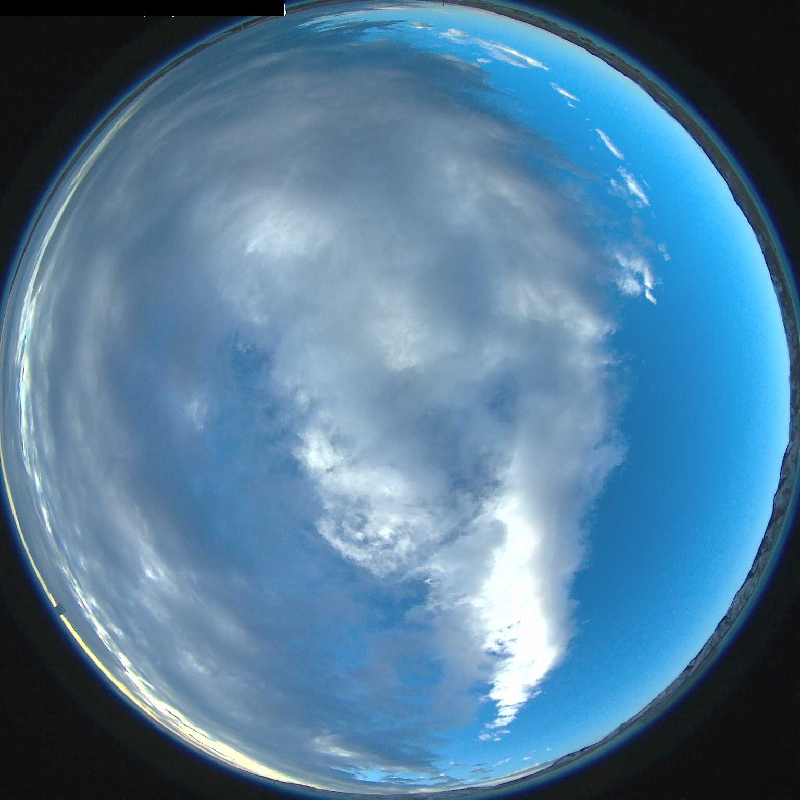

In [7]:
img = tf.keras.utils.load_img('/kaggle/input/cloud-images-19510/0101/0101075000.jpg', target_size = (800,800))
img

In [45]:
def undistort(img_path, zoom_out_factor = 1, balance=0.0, dim2=None, dim3=None):
    img = cv2.imread(img_path)
    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = dim1
    scaled_K = K.copy()
#     scaled_K[0][0] /= zoom_out_factor
#     scaled_K[1][1] /= zoom_out_factor
#     scaled_K[2][2] = 1.0  # Except that K[2][2] is always 1.0
    # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. OpenCV document failed to make this clear!
#     new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, , balance=balance)
    new_K = K.copy()
    new_K[0][0] /= zoom_out_factor
    new_K[1][1] /= zoom_out_factor
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_AREA, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    return undistorted_img


def undistort_wrapper(dist = 0.4, f = 400, **kwargs):
    dim = 2048
    DIM=(dim, dim)
    K=np.array([
        [f, 0.0, 1536/2], 
        [0.0, f, 1536/2], 
        [0.0, 0.0, 1.0]])
    D=np.array([[dist],[dist],[dist],[dist]])
    return undistort(**kwargs)


In [46]:
def undistorted_widget(**kwargs):
    image = undistort_wrapper(**kwargs)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(image,)


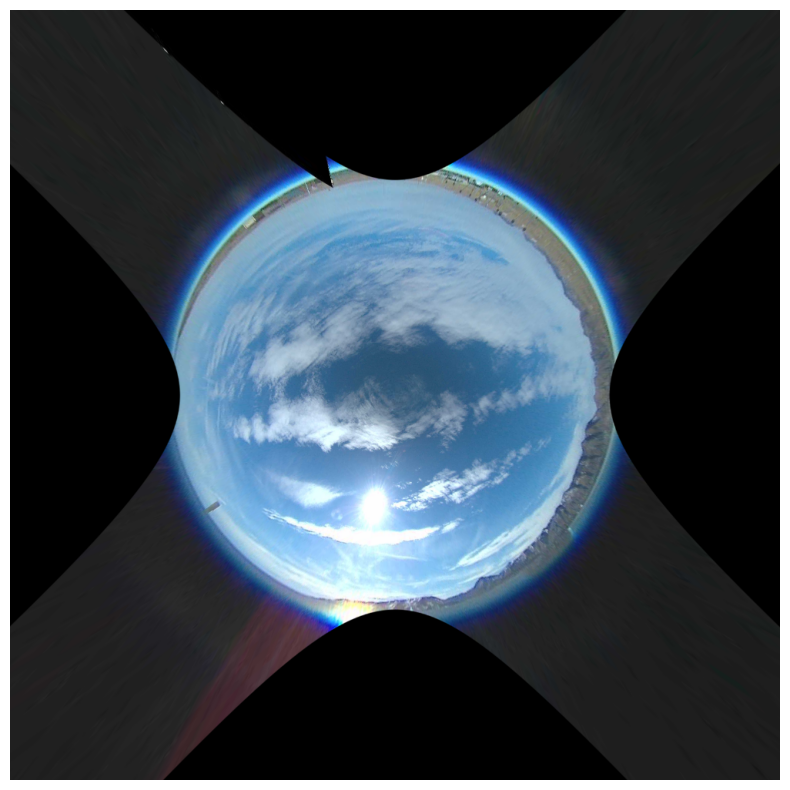

In [48]:
undistorted_widget(img_path = '/kaggle/input/cloud-images-19510/0105/0105112000.jpg',zoom_out_factor = 1,balance = 1)

In [41]:
%matplotlib inline


In [42]:
import IPython
from IPython.display import display
from ipywidgets import interact, IntSlider, fixed, FloatSlider, IntRangeSlider
balance = FloatSlider(min=0, max=1, value=1, description='Balance:')
display(balance)
display(interact(
    undistorted_widget,
    img_path = fixed('/kaggle/input/cloud-images-19510/0105/0105112000.jpg'),
    zoom_out_factor=FloatSlider(min=0, max=20, step=0.01, value=5),
    balance = balance
    
    
))

FloatSlider(value=1.0, description='Balance:', max=1.0)

interactive(children=(FloatSlider(value=5.0, description='zoom_out_factor', max=20.0, step=0.01), FloatSlider(…

<function __main__.undistorted_widget(**kwargs)>

In [ ]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [ ]:
%matplotlib notebook
import ipywidgets as widgets

# For explicitly displaying widgets
from IPython.display import display

# Just need these for the demo purposes here
from datetime import datetime
import matplotlib.pyplot as plt
demo_IntSlider_1 = widgets.IntSlider(
    min=1,                      # The minimum value
    max=100,                    # The maximum value
    description='Int Slider 1', # Label
    value=53,                   # Default value
)

# Display the widget
display(demo_IntSlider_1)

In [ ]:
u_img = undistort('/kaggle/input/cloud-images-19510/0105/0105112000.jpg',zoom_out_factor = 100,balance = 1)
tf.keras.utils.array_to_img(u_img)

In [ ]:

fig,ax = plt.subplots(nrows = 3, ncols = 3)
axes = ax.flatten()
for a in axes:
    a.imshow()

In [ ]:
tf.keras.utils.array_to_img(map1)

In [ ]:
tf.keras.utils.array_to_img(undistort('/kaggle/input/cloud-images-19510/0101/0101075000.jpg',balance = 1), )

In [ ]:
plt.imshow(img)

In [ ]:
img

# Data Preprocessing

## Creating Tensorflow Datsets

In [12]:
base_path = '/kaggle/input/cloud-images-19510'

In [13]:
image_paths = [sorted([os.path.join(root,file) for file in files if file.endswith('.jpg')]) for root,dirs,files in os.walk(base_path) if len(dirs) == 0]

NameError: name 'os' is not defined

In [ ]:
flattened_image_paths = sorted([os.path.join(root,file) for root,dirs,files in os.walk(base_path) for file in files if not file.endswith('.csv')])

In [7]:
def undistort_from_array(img, dim2 = None, dim3 = None, balance = 0):
    dim1 = img.shape[:2][::-1]  #dim1 is the dimension of input image to un-distort
    assert dim1[0]/dim1[1] == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"
    if not dim2:
        dim2 = dim1
    if not dim3:
        dim3 = dim1
    scaled_K = K * dim1[0] / DIM[0]  # The values of K is to scale with image dimension.
    scaled_K[2][2] = 1.0  # Except that K[2][2] is always 1.0
    # This is how scaled_K, dim2 and balance are used to determine the final K used to un-distort image. OpenCV document failed to make this clear!
    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, np.eye(3), balance=balance)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    undistorted_img = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2RGB)
    undistorted_img = cv2.resize(undistorted_img, (1000,1000))
    return undistorted_img
    

In [8]:
import tensorflow as tf

class Preprocessor:
    def __init__(
            self,
            filepaths : list[str]
    ):
        self.filepaths = filepaths
        self.dataset = None

    def get_dataset_iterator(self,func):
        if self.dataset:
            return self.dataset
        self.dataset = tf.data.Dataset.from_tensor_slices(self.filepaths)
        self.dataset = self.dataset.map(func, num_parallel_calls=tf.data.AUTOTUNE)
        # self.dataset = self.dataset.cache()
        # self.dataset = self.dataset.shuffle(buffer_size=1000)
        # self.dataset = self.dataset.batch(32)
        # self.dataset = self.dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return self.dataset
@tf.function
def load_preprocess_y(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [128, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

@tf.function
def get_image_from_path(file_path):
    return image

@tf.py_function(Tout=tf.float64)
def get_undistorted_img(file_path):
    path_str = file_path.numpy().decode('utf-8')
    image = undistort(path_str,zoom_out_factor = 10,balance = 1)
    return tf.convert_to_tensor(image,dtype = tf.float64)

2024-06-14 19:44:17.088888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 19:44:17.089017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 19:44:17.254502: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


KeyboardInterrupt: 

In [ ]:
train_ds_x = Preprocessor(flattened_image_paths).get_dataset_iterator(get_undistorted_img)
# train_ds_x.map(get_undistorted_img)

In [ ]:
image_iter = train_ds_x.as_numpy_iterator()

In [ ]:
def show_grid_samples(ncols = 3,nrows = 3,scale = 1,**kwargs):
    figsize = (ncols * scale, nrows * scale)
    plt.tight_layout()
    fig,ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = figsize)
    axes = ax.flatten()
    for a in axes:
        a.imshow(image_iter.next()/255, interpolation = 'nearest')
        a.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.show()

In [10]:
%matplotlib notebook

In [11]:
show_grid_samples(ncols = 3,nrows = 10,scale = 5)

NameError: name 'show_grid_samples' is not defined